In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
!python3 -c "import torch; print(torch.__version__)"

1.13.1+cu116


In [2]:
#!pip3 install torch torchvision
import torch
import torch.nn as nn
import numpy as np
from numpy import inf

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(0)

In [8]:
print(device)

cuda


In [14]:
class BaseGNNLayer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        lim = 1  
        self.w_self = (-2 * lim * torch.rand(input_dim, output_dim) + lim).to(device)
        self.w_neigh = (-2 * lim * torch.rand(input_dim, output_dim) + lim).to(device)
        self.w_readout = (-2 * lim * torch.rand(input_dim, output_dim) + lim).to(device)

    def forward(self, node_feats, adj_matrix):
        node_feats_self = torch.mm(node_feats, self.w_self).to(device) 
        node_feats_neigh = torch.mm(torch.mm(adj_matrix, node_feats), self.w_neigh).to(device)
        node_feats_readout = torch.mm(torch.mm(torch.ones(len(adj_matrix), len(adj_matrix)).to(device),
                                           node_feats), self.w_readout).to(device)
        next_node_feats = node_feats_self + \
                        node_feats_neigh + \
                        node_feats_readout
        return next_node_feats

In [10]:
threshold=1
def act_fn(x):
    #return torch.clamp(x, min=-threshold, max=threshold)
    return torch.clamp(x, min=-threshold, max=threshold).to(device)

In [11]:
class BaseGNNModule(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=act_fn):
        super().__init__()
        self.layers = nn.ModuleList([BaseGNNLayer(input_dim, hidden_dim).to(device)])
        for i in range(num_layers - 2):
            self.layers.append(BaseGNNLayer(hidden_dim, hidden_dim).to(device))
        self.layers.append(BaseGNNLayer(hidden_dim, output_dim).to(device))
        self.act_fn = act_fn

    def forward(self, x, adj_matrix):
        for layer in self.layers:
            x = self.act_fn(layer(x, adj_matrix))
        return x

In [12]:
class MLPModule(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=torch.tanh):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim).to(device)])
        for i in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim).to(device))
        self.layers.append(nn.Linear(hidden_dim, output_dim).to(device))
        self.act_fn = act_fn

    def forward(self, x):
        for layer in self.layers:
            x = self.act_fn(layer(x))
        return torch.sigmoid(x)

In [ ]:
csv

[[64, 0.5, 1, 0, [32, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 1, 1, [19, 22, 25, 32, 32, 32, 32]],
 [64, 0.5, 1, 2, [22, 23, 27, 32, 32, 32, 32]],
 [64, 0.5, 1, 3, [29, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 1, 4, [0, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 1, 5, [31, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 1, 6, [24, 24, 23, 14, 8, 12, 5]],
 [64, 0.5, 1, 7, [31, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 1, 8, [28, 19, 12, 11, 5, 10, 10]],
 [64, 0.5, 1, 9, [29, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 2, 0, [15, 27, 24, 32, 32, 32, 32]],
 [64, 0.5, 2, 1, [28, 31, 32, 32, 32, 32, 32]],
 [64, 0.5, 2, 2, [25, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 2, 3, [0, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 2, 4, [5, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 2, 5, [11, 15, 13, 9, 8, 5, 0]],
 [64, 0.5, 2, 6, [0, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 2, 7, [21, 29, 28, 30, 32, 32, 32]],
 [64, 0.5, 2, 8, [31, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 2, 9, [0, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 3, 0, [3, 5, 4, 0, 0, 0, 0]],
 [64, 0.5, 3, 1, [0, 0, 0, 0, 0, 0, 0]],


In [ ]:
csv = []

for d in [64]:
    for r in [0.5]:
        for num_layers in [1,2,3]:
            for mpnn_idx in range(10):  # There will be 10 plots.
                # Initialize random BaseGNN model with sum aggregation.
                base_gnn_gr = BaseGNNModule(input_dim=d, hidden_dim=d, output_dim=d,
                                         num_layers=num_layers, act_fn=act_fn).to(device)

                # Initialize random MLP classifier acting on final mean-pooled embedding.
                mlp = MLPModule(input_dim=d, hidden_dim=100, output_dim=1, 
                            num_layers=2, act_fn=torch.tanh).to(device)
                
                #torch.save(base_gnn_gr,f"/Users/.../Desktop/.../th1_base_gnn_gr_num_{num_layers}_mpnn_{mpnn_idx}.pth")
                #torch.save(mlp,f"/Users/.../Desktop/.../th1_gr_mlp_num_{num_layers}_mpnn_{mpnn_idx}.pth")

                # Keep track of proportions of graphs classified as 1.
                proportions = []

                # Create plot with x-axis an increasing seq of number of graph nodes.
                for graph_dim in [10, 50, 100, 500, 1000, 2000, 5000, 
                                  10000, 15000, 20000, 50000, 100000,
                                  150000, 200000, 500000]:
                    print(graph_dim)

                  # Generate 32 graphs for each such graph dimension, to keep
                  # track of the proportion that is classified as 1. 
                    classifications = []

                    for idx in range(2**5):
                        # Generate graph to be fed to the BaseGNN.
                        half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                                              torch.eye(graph_dim))).to(device)
                        adj_matrix = half_matrix + half_matrix.T
                        initial_node_feats = torch.rand(graph_dim, d).to(device)

                        # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                        output = base_gnn_gr(initial_node_feats, adj_matrix).mean(axis=0)
                        # Apply MLP classifier to the resulting output.
                        apply_classifier = mlp(output)

                        # If smaller than 1/2, output 0, else output 1.
                        if apply_classifier <= 0.5:
                            classifications.append(0)
                        else:
                            classifications.append(1)

                    # Calculate proportion of graphs classified as 1.
                    classifications = np.array(classifications)
                    proportions.append((classifications == 1).sum())

                csv.append([d,r,num_layers, mpnn_idx, proportions])
                print(csv[-1])


10
50
100
500
1000
2000
5000
10000
15000
20000
50000


In [ ]:
import matplotlib.pyplot as plt
import pickle

In [ ]:

#generate 3 images
csv_numLayer_1 = [item[-1] for item in csv if item[2] == 1]
csv_numLayer_2 = [item[-1] for item in csv if item[2] == 2]
csv_numLayer_3 = [item[-1] for item in csv if item[2] == 3]

In [ ]:
#path_1 = f"/Users/.../Desktop/.../sum_gr_num_1.pickle"
with open(path_1, 'wb') as handle:
    pickle.dump(csv_numLayer_1,handle)

#path_2 = f"/Users/.../Desktop/.../sum_gr_num_2.pickle"
with open(path_2, 'wb') as handle:
    pickle.dump(csv_numLayer_2,handle)

#path_3 = f"/Users/.../Desktop/.../sum_gr_num_3.pickle"
with open(path_3, 'wb') as handle:
    pickle.dump(csv_numLayer_3,handle)

In [ ]:
plt.rcParams['figure.dpi'] = 600

In [ ]:
x = [10, 50, 100, 500, 1000, 2000, 5000]
#x = [10, 50, 100]

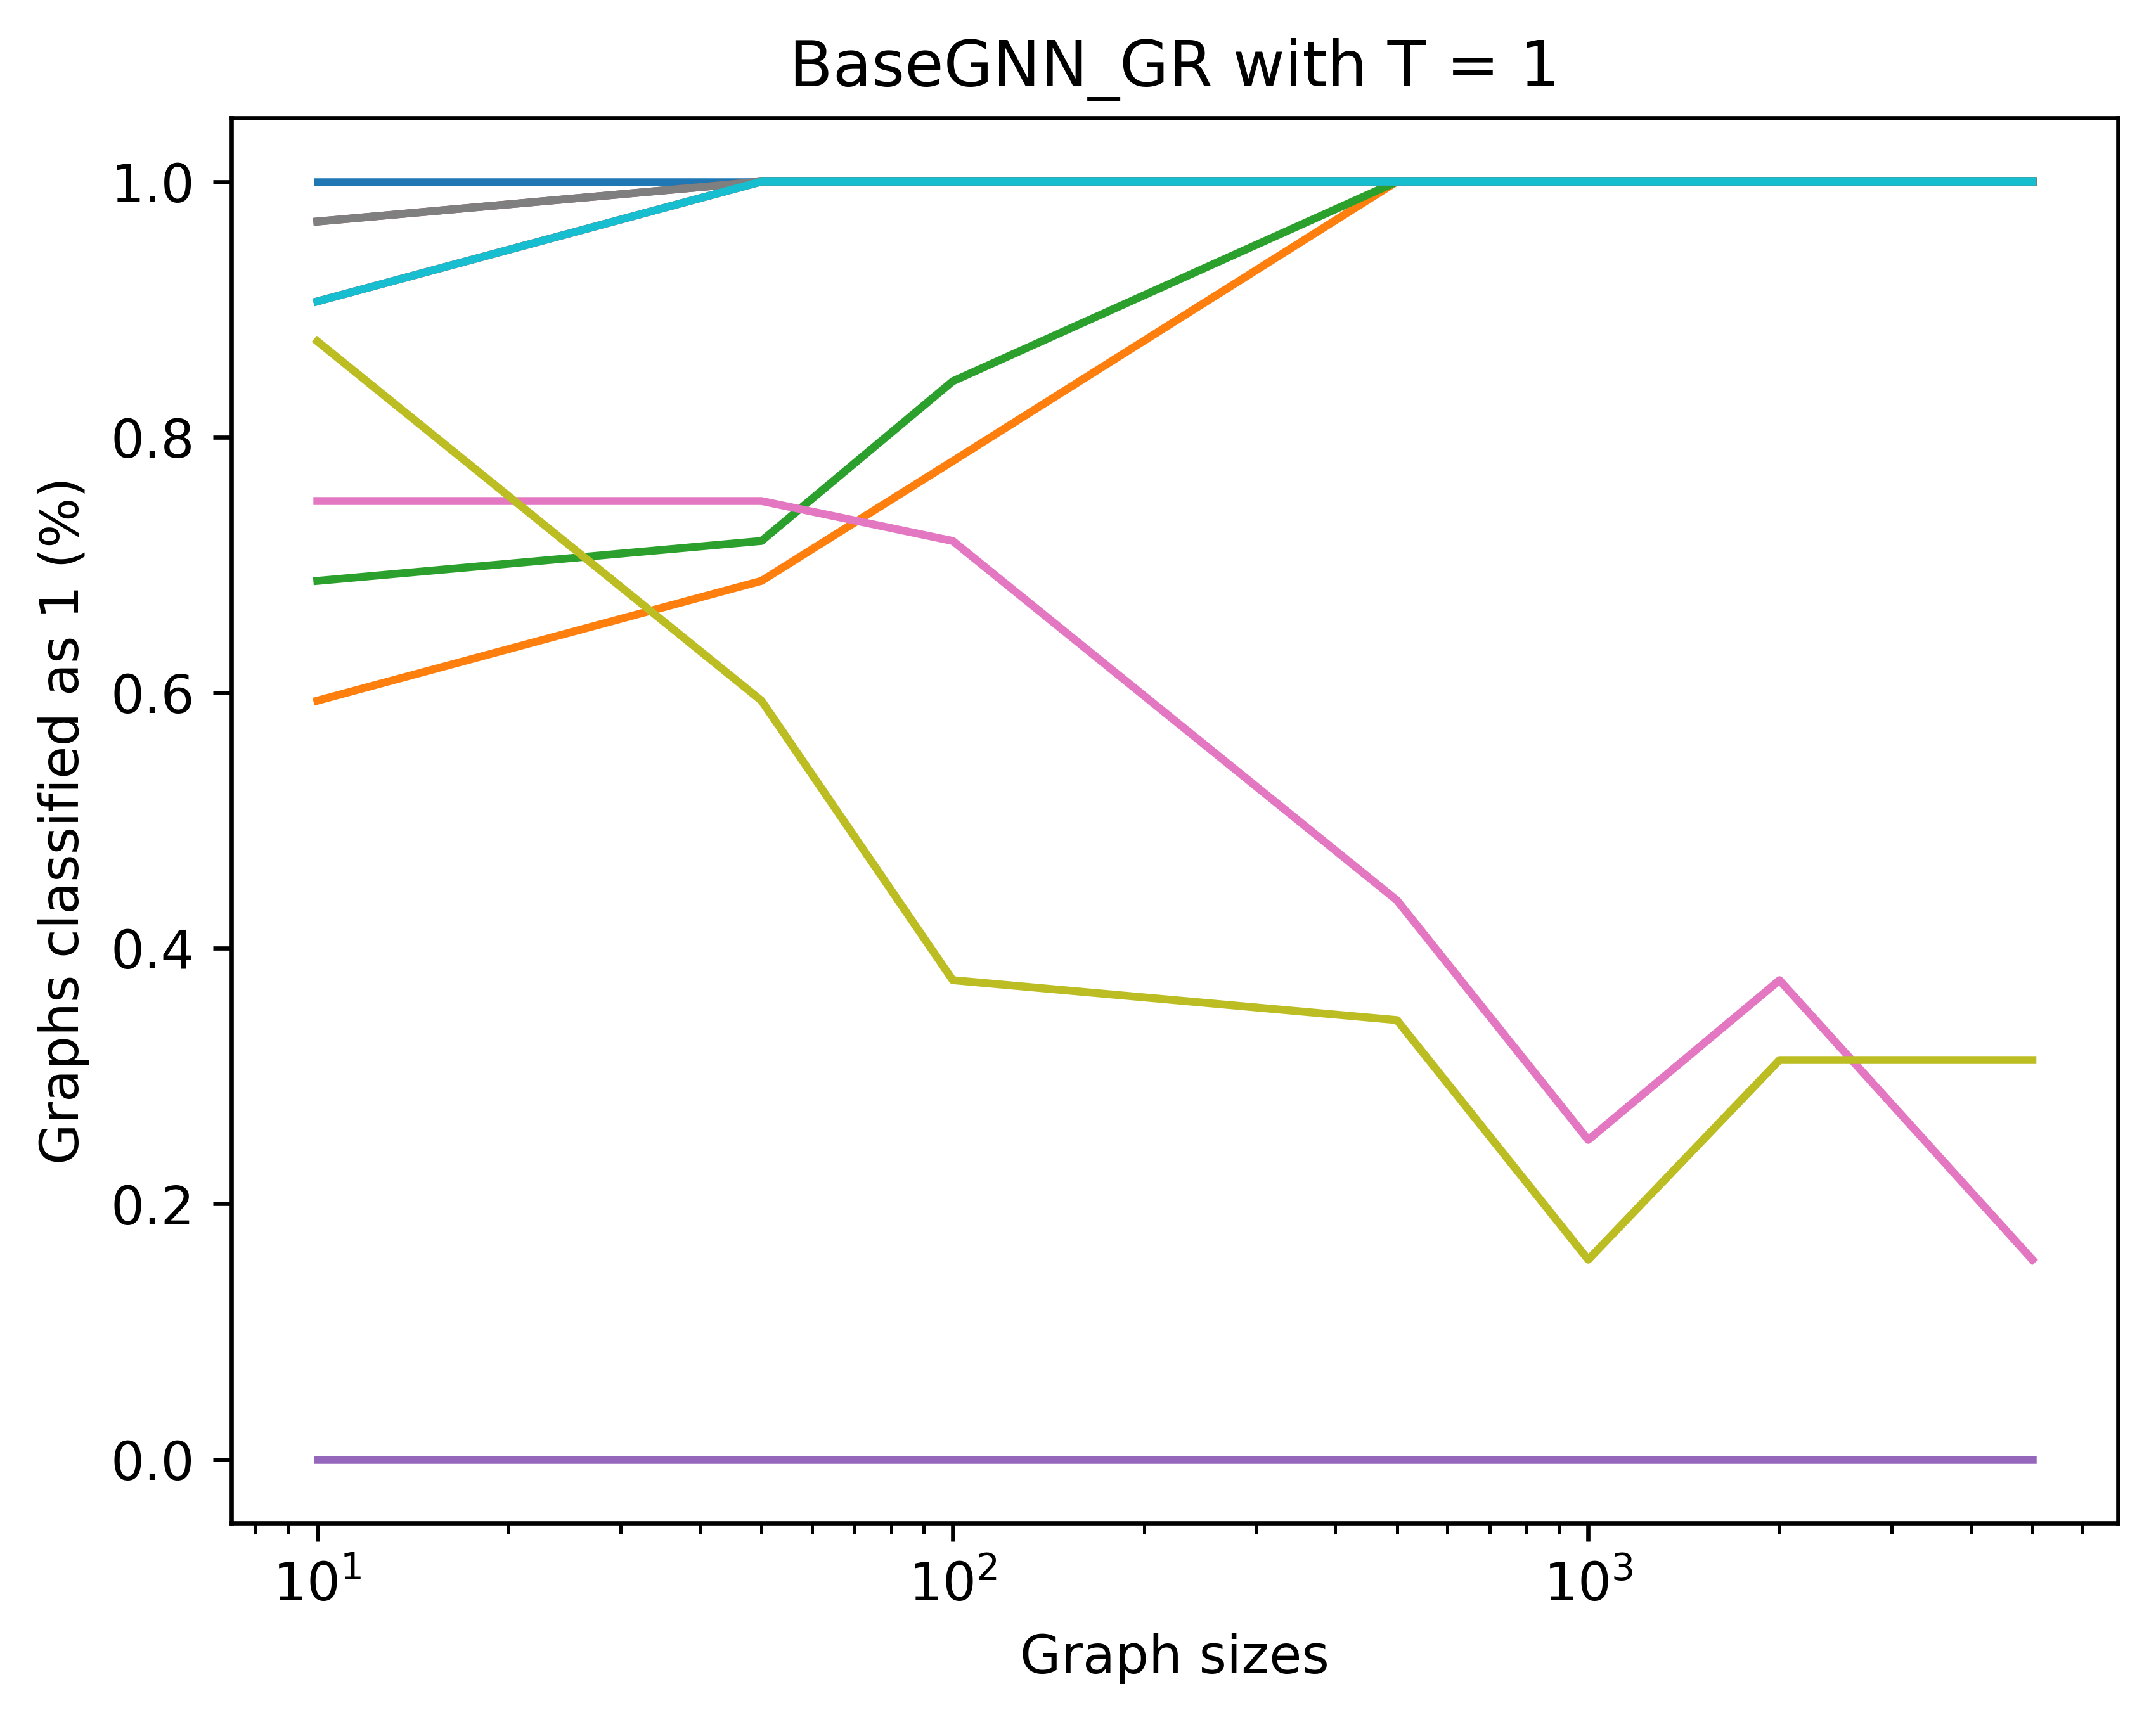

In [ ]:
for y in csv_numLayer_1:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'BaseGNN_GR with T = 1')
#plt.savefig('/Users/.../Desktop/.../visuals/sum_gr_no_layers_1')
plt.show()

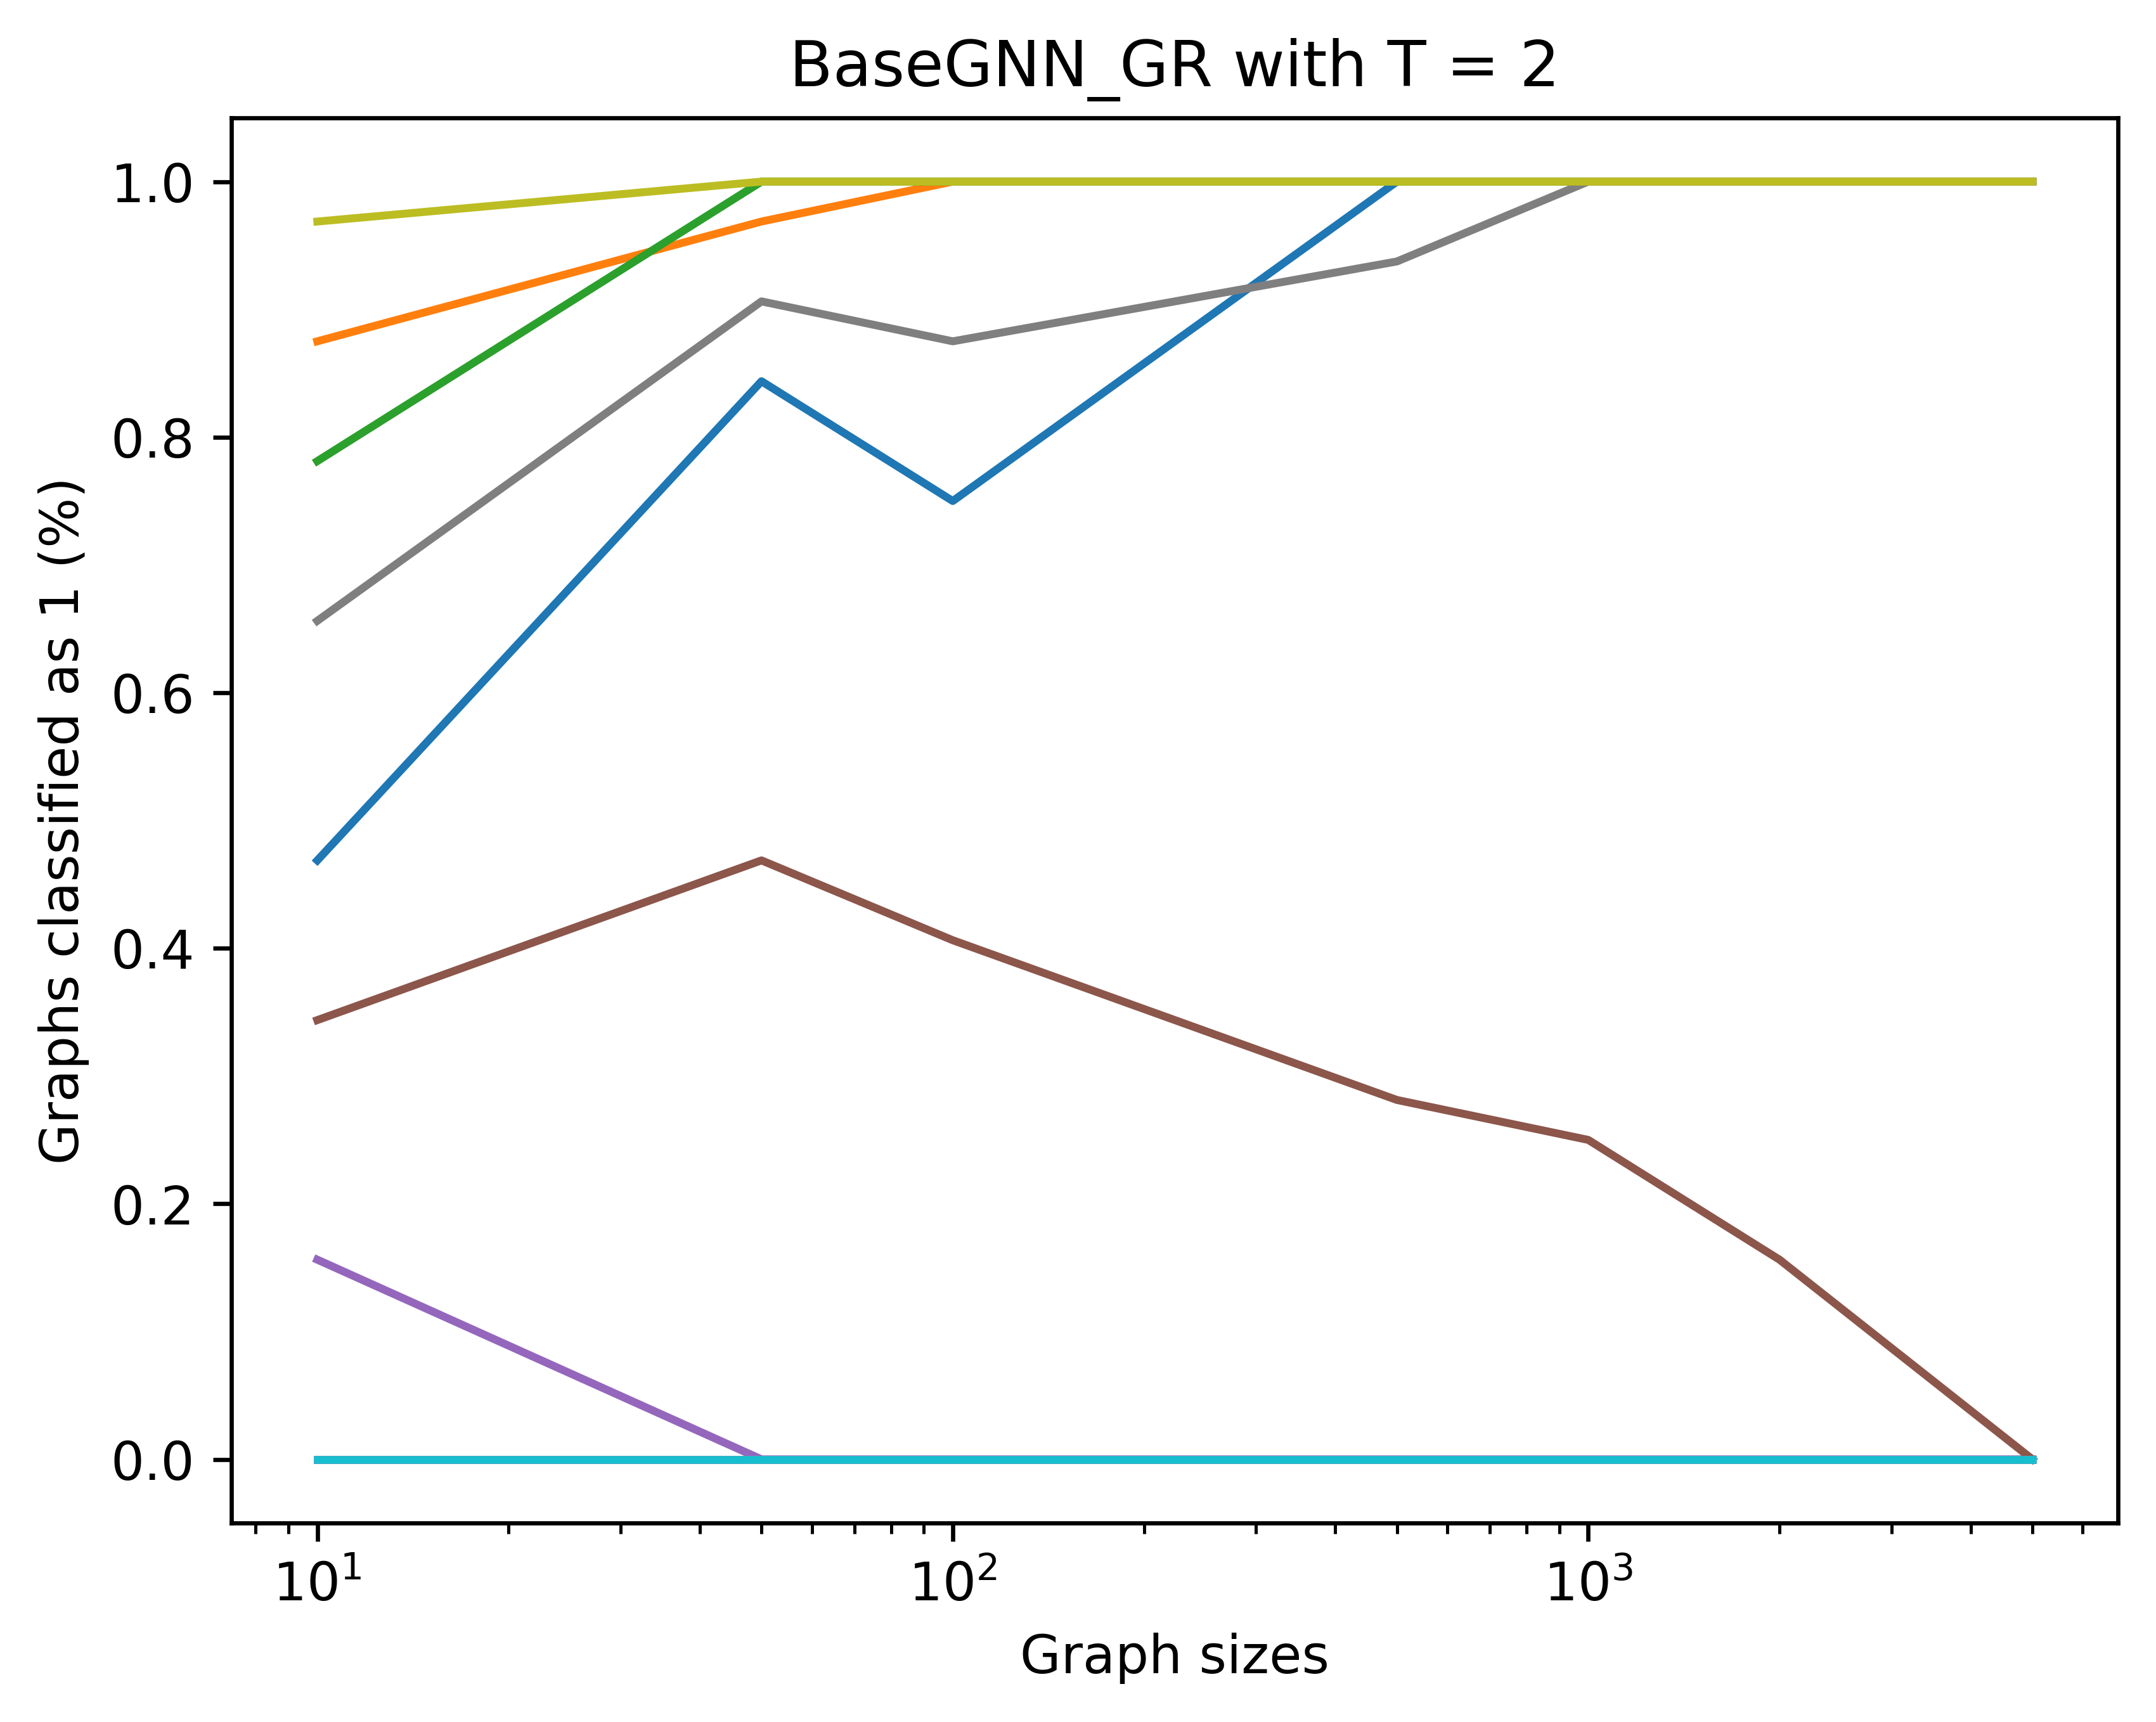

In [ ]:
for y in csv_numLayer_2:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'BaseGNN_GR with T = 2')
#plt.savefig('/Users/.../Desktop/.../visuals/sum_gr_no_layers_2')
plt.show()

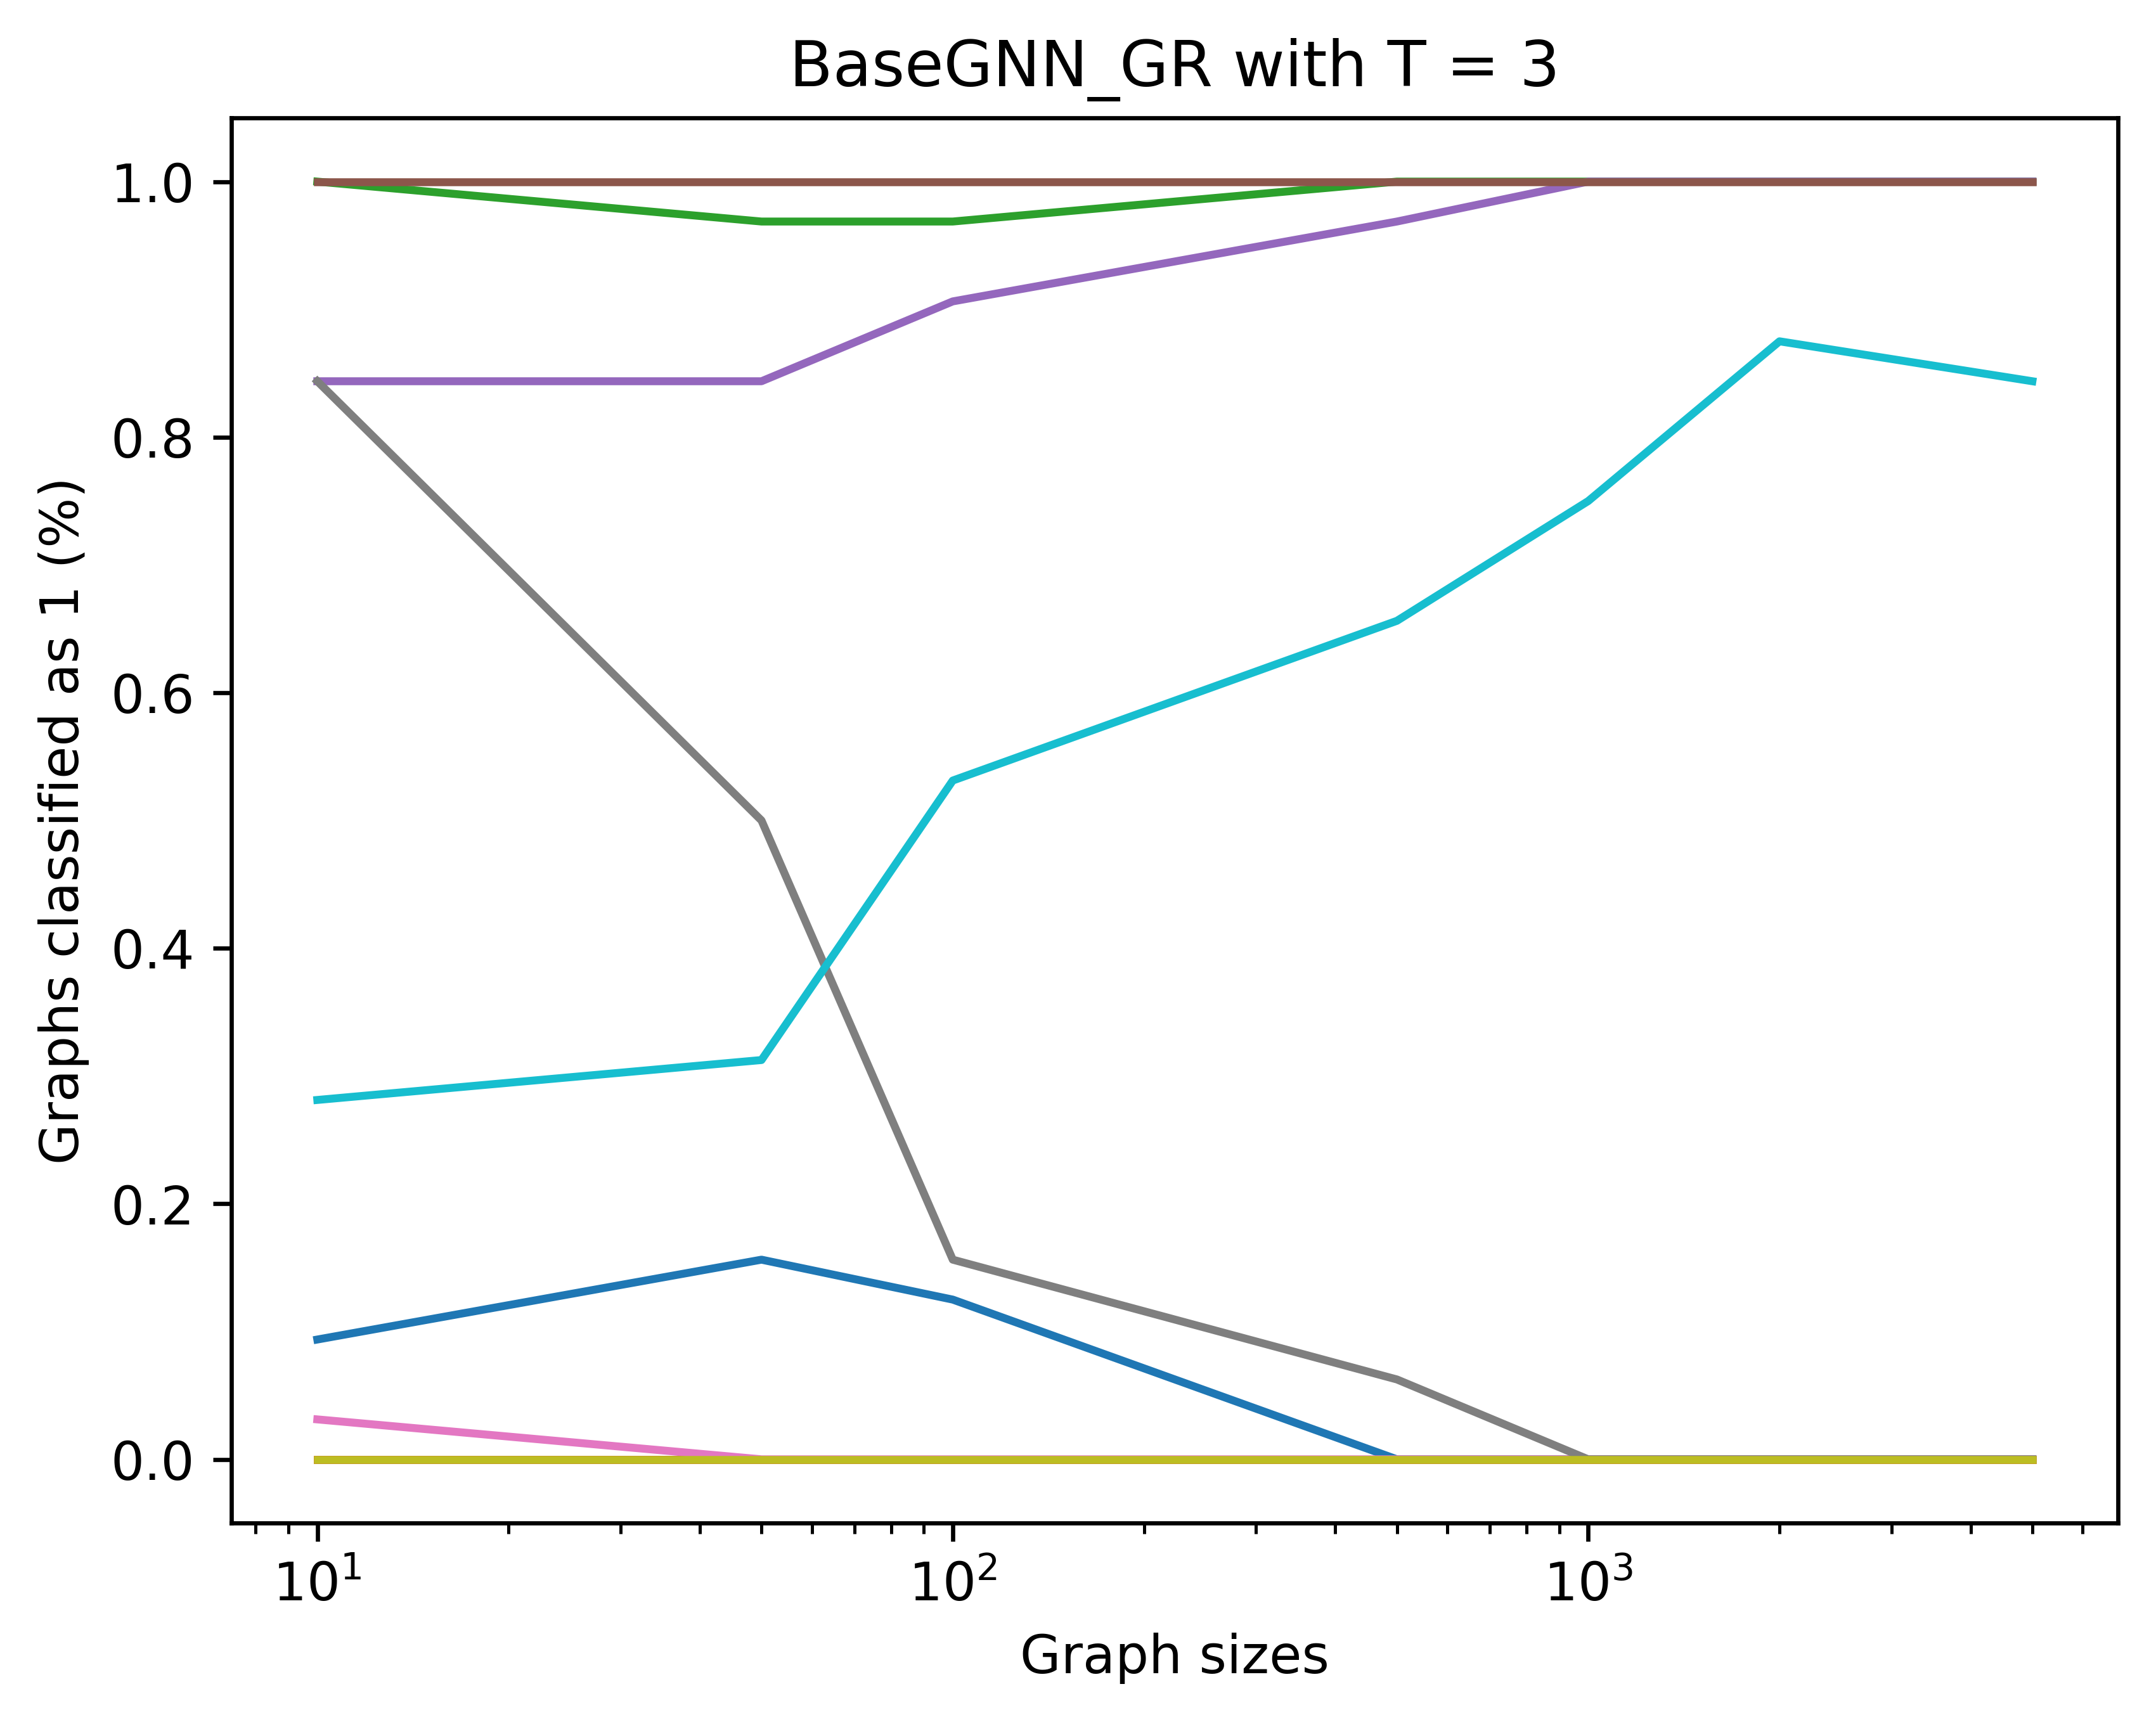

In [ ]:
for y in csv_numLayer_3:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'BaseGNN_GR with T = 3')
#plt.savefig('/Users/.../Desktop/.../visuals/sum_gr_no_layers_3')
plt.show()

In [ ]:
csv

[[64, 0.5, 1, 0, [32, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 1, 1, [19, 22, 25, 32, 32, 32, 32]],
 [64, 0.5, 1, 2, [22, 23, 27, 32, 32, 32, 32]],
 [64, 0.5, 1, 3, [29, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 1, 4, [0, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 1, 5, [31, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 1, 6, [24, 24, 23, 14, 8, 12, 5]],
 [64, 0.5, 1, 7, [31, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 1, 8, [28, 19, 12, 11, 5, 10, 10]],
 [64, 0.5, 1, 9, [29, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 2, 0, [15, 27, 24, 32, 32, 32, 32]],
 [64, 0.5, 2, 1, [28, 31, 32, 32, 32, 32, 32]],
 [64, 0.5, 2, 2, [25, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 2, 3, [0, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 2, 4, [5, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 2, 5, [11, 15, 13, 9, 8, 5, 0]],
 [64, 0.5, 2, 6, [0, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 2, 7, [21, 29, 28, 30, 32, 32, 32]],
 [64, 0.5, 2, 8, [31, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 2, 9, [0, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 3, 0, [3, 5, 4, 0, 0, 0, 0]],
 [64, 0.5, 3, 1, [0, 0, 0, 0, 0, 0, 0]],


In [ ]:
csv = []

for d in [64]:
    for r in [0.5]:
        for num_layers in [1,2,3]:
            for mpnn_idx in range(10):  # There will be 10 plots.
                # Initialize random BaseGNN model with sum aggregation.
                #base_gnn_gr = BaseGNNModule(input_dim=d, hidden_dim=d, output_dim=d,
                                         #num_layers=num_layers, act_fn=act_fn)

                # Initialize random MLP classifier acting on final mean-pooled embedding.
                #mlp = MLPModule(input_dim=d, hidden_dim=100, output_dim=1, 
                            #num_layers=2, act_fn=torch.tanh)
                
                base_gnn_gr = torch.load(f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/base_gnn_gr_num_{num_layers}_mpnn_{mpnn_idx}.pth")
                mlp = torch.load(f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/mlp_num_{num_layers}_mpnn_{mpnn_idx}.pth")

                # Keep track of proportions of graphs classified as 1.
                proportions = []

                # Create plot with x-axis an increasing seq of number of graph nodes.
                for graph_dim in [50000]:

                  # Generate 32 graphs for each such graph dimension, to keep
                  # track of the proportion that is classified as 1. 
                    classifications = []

                    for idx in range(2**5):
                        # Generate graph to be fed to the BaseGNN.
                        half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                                              torch.eye(graph_dim)))
                        adj_matrix = half_matrix + half_matrix.T
                        initial_node_feats = torch.rand(graph_dim, d) 

                        # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                        output = base_gnn_gr(initial_node_feats, adj_matrix).mean(axis=0)

                        # Apply MLP classifier to the resulting output.
                        apply_classifier = mlp(output)

                        # If smaller than 1/2, output 0, else output 1.
                        if apply_classifier <= 0.5:
                            classifications.append(0)
                        else:
                            classifications.append(1)

                    # Calculate proportion of graphs classified as 1.
                    classifications = np.array(classifications)
                    proportions.append((classifications == 1).sum())

                csv.append([d,r,num_layers, mpnn_idx, proportions])
                print(csv[-1])


[64, 0.5, 1, 0, [31]]
[64, 0.5, 1, 1, [0]]
[64, 0.5, 1, 2, [0]]
[64, 0.5, 1, 3, [0]]
[64, 0.5, 1, 4, [32]]
[64, 0.5, 1, 5, [32]]
[64, 0.5, 1, 6, [32]]
[64, 0.5, 1, 7, [0]]
[64, 0.5, 1, 8, [19]]
[64, 0.5, 1, 9, [32]]
[64, 0.5, 2, 0, [32]]
[64, 0.5, 2, 1, [4]]
[64, 0.5, 2, 2, [32]]
[64, 0.5, 2, 3, [0]]
[64, 0.5, 2, 4, [32]]
[64, 0.5, 2, 5, [0]]
[64, 0.5, 2, 6, [0]]
[64, 0.5, 2, 7, [32]]
[64, 0.5, 2, 8, [5]]
[64, 0.5, 2, 9, [32]]
[64, 0.5, 3, 0, [32]]
[64, 0.5, 3, 1, [0]]
[64, 0.5, 3, 2, [32]]
[64, 0.5, 3, 3, [32]]
[64, 0.5, 3, 4, [32]]
[64, 0.5, 3, 5, [32]]
[64, 0.5, 3, 6, [1]]
[64, 0.5, 3, 7, [0]]
[64, 0.5, 3, 8, [32]]
[64, 0.5, 3, 9, [0]]


In [ ]:
path_1 = f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/base_gnn_num_1.pickle"
with open(path_1, 'rb') as handle:
    csv_numLayer_1 = pickle.load(handle)

path_2 = f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/base_gnn_num_2.pickle"
with open(path_2, 'rb') as handle:
    csv_numLayer_2 = pickle.load(handle)

path_3 = f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/base_gnn_num_3.pickle"
with open(path_3, 'rb') as handle:
    csv_numLayer_3 = pickle.load(handle)

In [ ]:
print(csv_numLayer_1)

[[14, 2, 8, 12, 14, 19, 15, 23, 30, 29], [24, 2, 6, 4, 11, 2, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 11, 13, 25, 17, 2, 0, 0, 0, 0], [10, 31, 32, 32, 31, 27, 30, 32, 32, 32], [14, 19, 19, 29, 30, 31, 30, 31, 32, 32], [32, 32, 32, 32, 32, 32, 32, 32, 32, 32], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [9, 24, 24, 30, 27, 26, 26, 29, 23, 20], [32, 32, 32, 32, 32, 32, 32, 32, 32, 32]]


In [ ]:
print(csv_numLayer_2)

[[27, 7, 6, 25, 31, 32, 32, 32, 32, 32], [0, 3, 3, 8, 5, 10, 2, 10, 5, 3], [19, 14, 29, 28, 30, 24, 28, 32, 32, 32], [5, 3, 7, 2, 0, 2, 0, 0, 0, 0], [32, 30, 32, 32, 32, 32, 32, 32, 32, 32], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [24, 29, 25, 29, 27, 19, 6, 5, 1, 1], [15, 32, 32, 30, 24, 18, 4, 3, 0, 0], [13, 11, 9, 20, 20, 16, 22, 18, 9, 13], [9, 30, 26, 32, 32, 32, 32, 32, 32, 32]]


In [ ]:
print(csv_numLayer_3)

[[7, 18, 16, 14, 10, 16, 29, 32, 32, 32], [16, 21, 20, 25, 25, 27, 9, 2, 3, 4], [29, 29, 31, 26, 28, 30, 32, 32, 32, 32], [11, 29, 28, 30, 31, 31, 31, 31, 32, 32], [30, 27, 22, 31, 32, 31, 31, 30, 32, 32], [24, 17, 19, 21, 20, 26, 26, 32, 29, 32], [0, 3, 9, 14, 7, 2, 2, 2, 6, 2], [1, 1, 13, 23, 18, 20, 10, 2, 3, 2], [30, 23, 23, 31, 32, 32, 32, 32, 32, 32], [1, 0, 1, 1, 0, 0, 0, 0, 0, 0]]


In [ ]:
ext_csv_numLayer_1 = [item[-1] for item in csv if item[2] == 1]
ext_csv_numLayer_2 = [item[-1] for item in csv if item[2] == 2]
ext_csv_numLayer_3 = [item[-1] for item in csv if item[2] == 3]

In [ ]:
print(ext_csv_numLayer_1)
print(ext_csv_numLayer_2)
print(ext_csv_numLayer_3)

[[31], [0], [0], [0], [32], [32], [32], [0], [19], [32]]
[[32], [4], [32], [0], [32], [0], [0], [32], [5], [32]]
[[32], [0], [32], [32], [32], [32], [1], [0], [32], [0]]


In [ ]:
x = [10, 50, 100, 500, 1000, 2000, 5000, 10000, 15000, 20000, 50000]

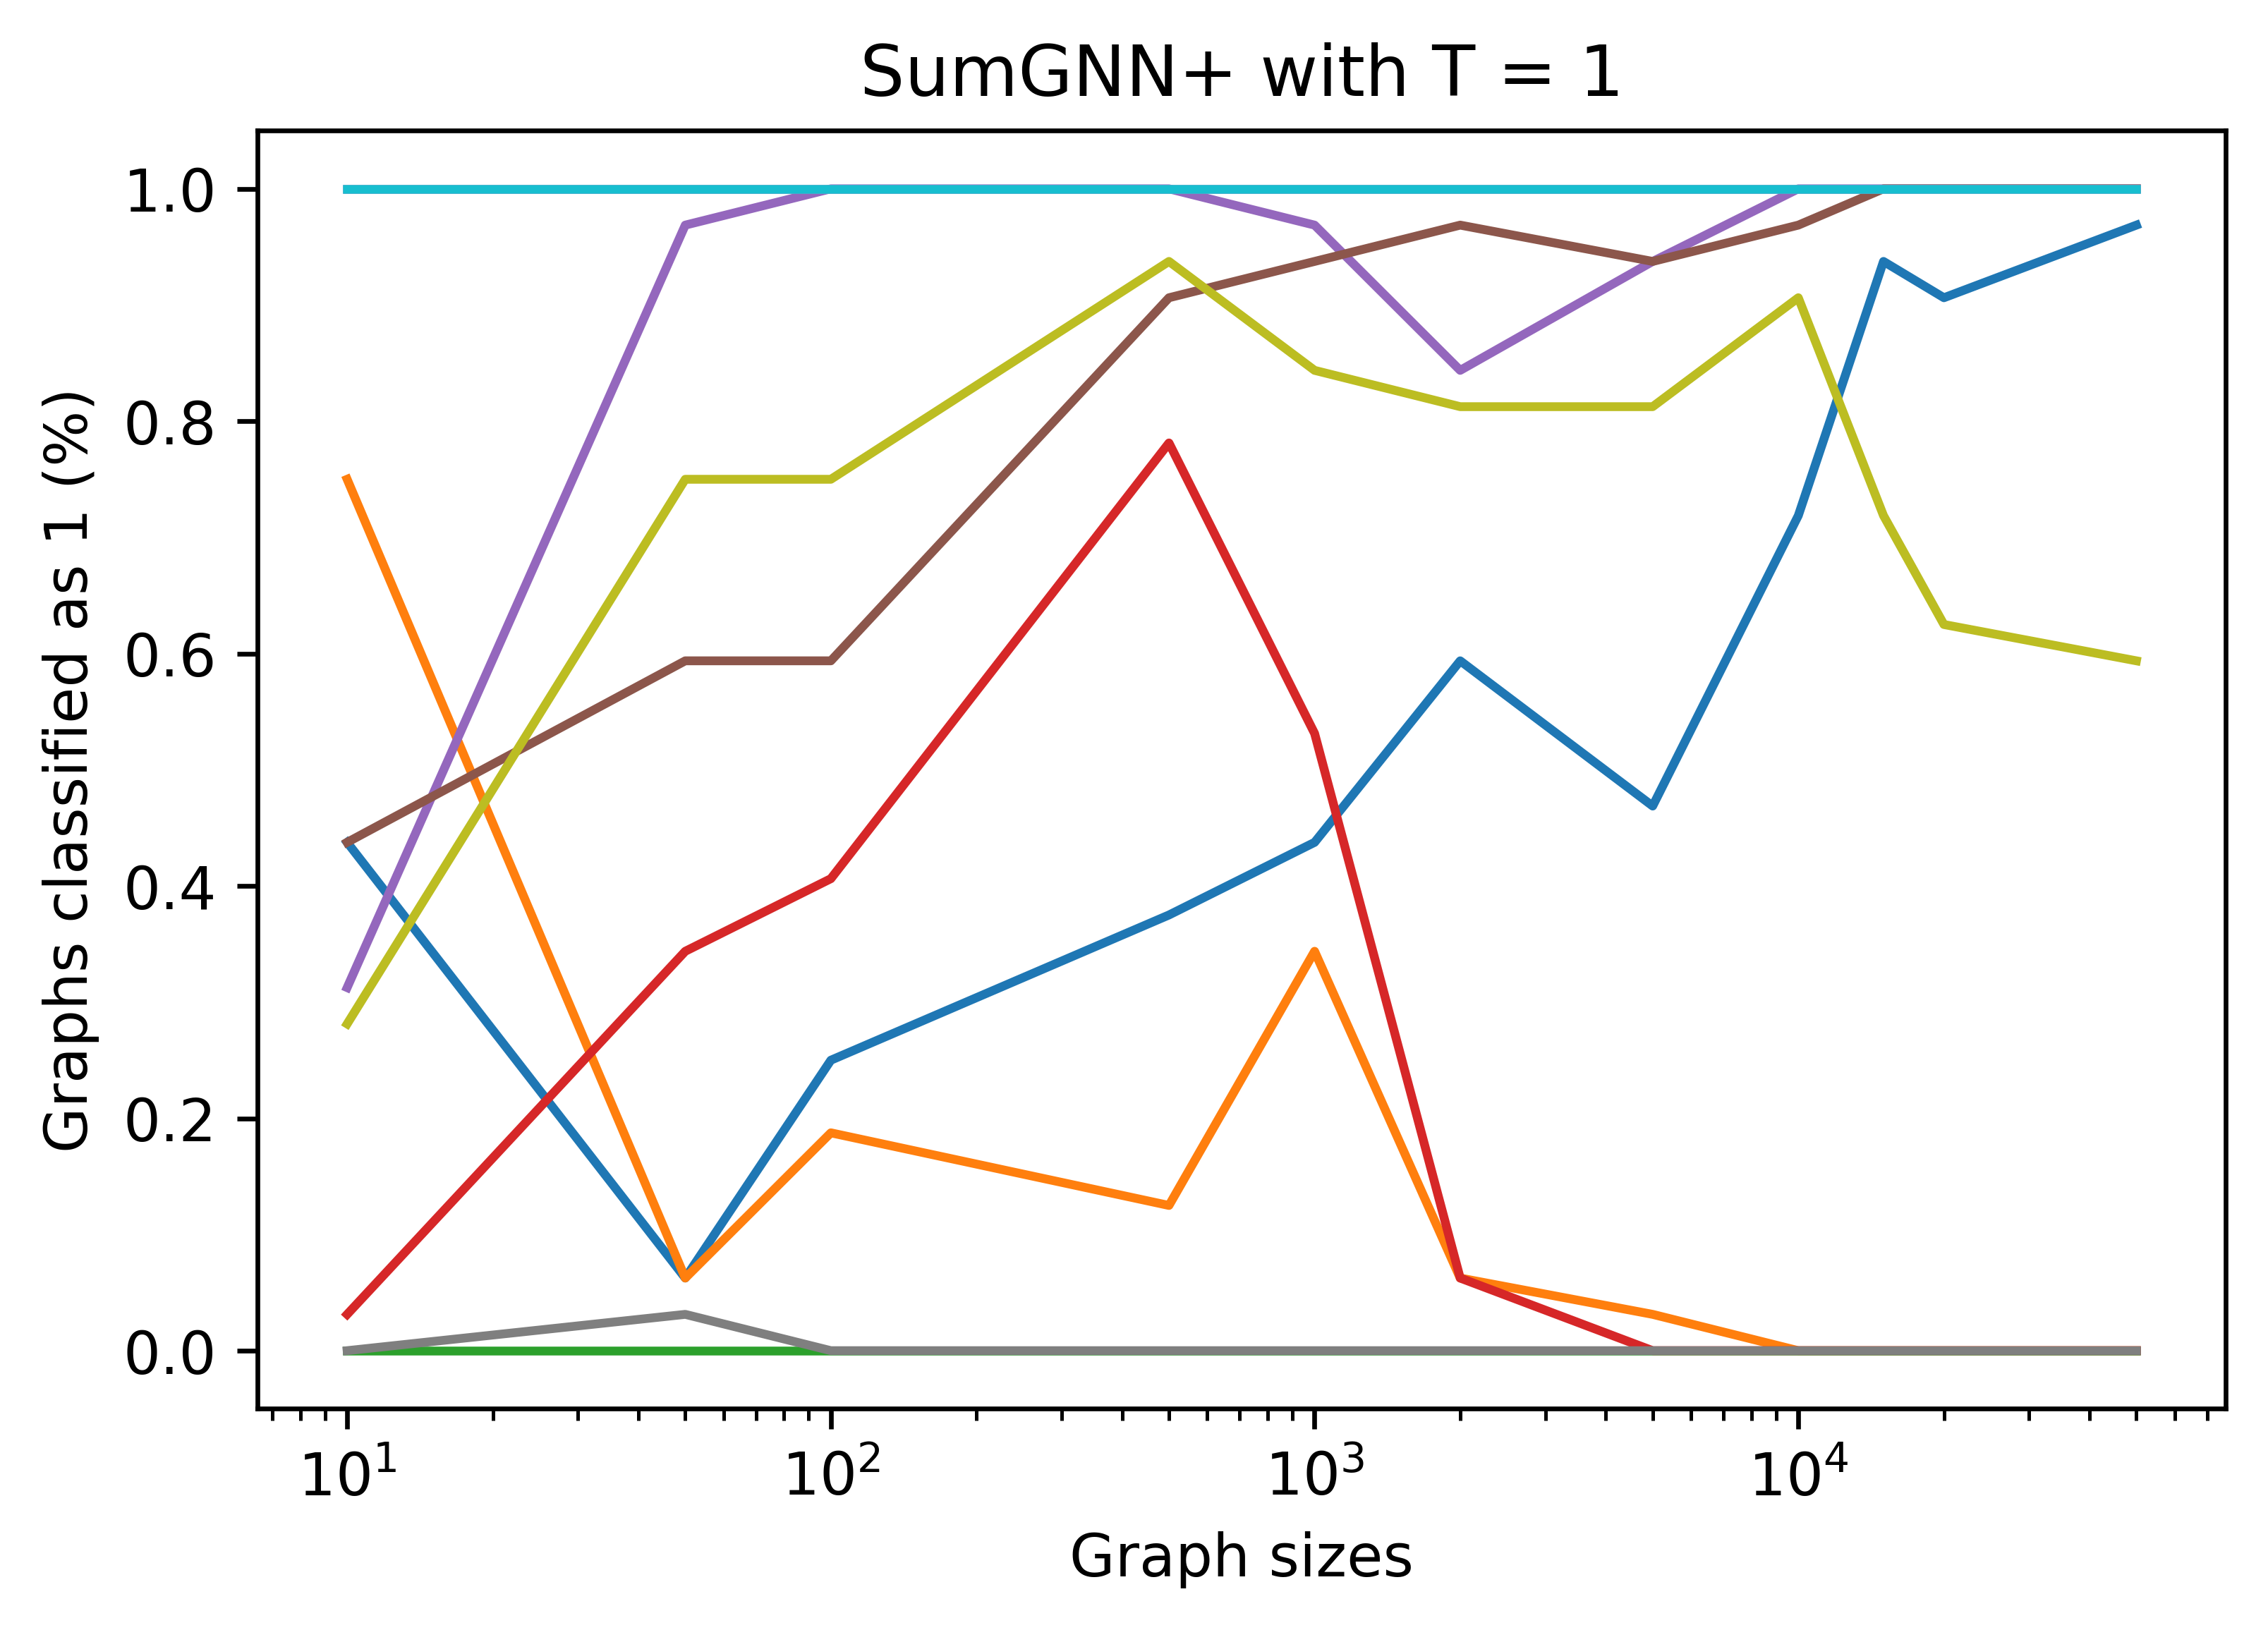

In [ ]:
for idx,y in enumerate(csv_numLayer_1):
  y = [item/32 for item in y] + [ext_csv_numLayer_1[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'SumGNN+ with T = 1')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/Added_SumGNN+ with T = 1')
plt.show()

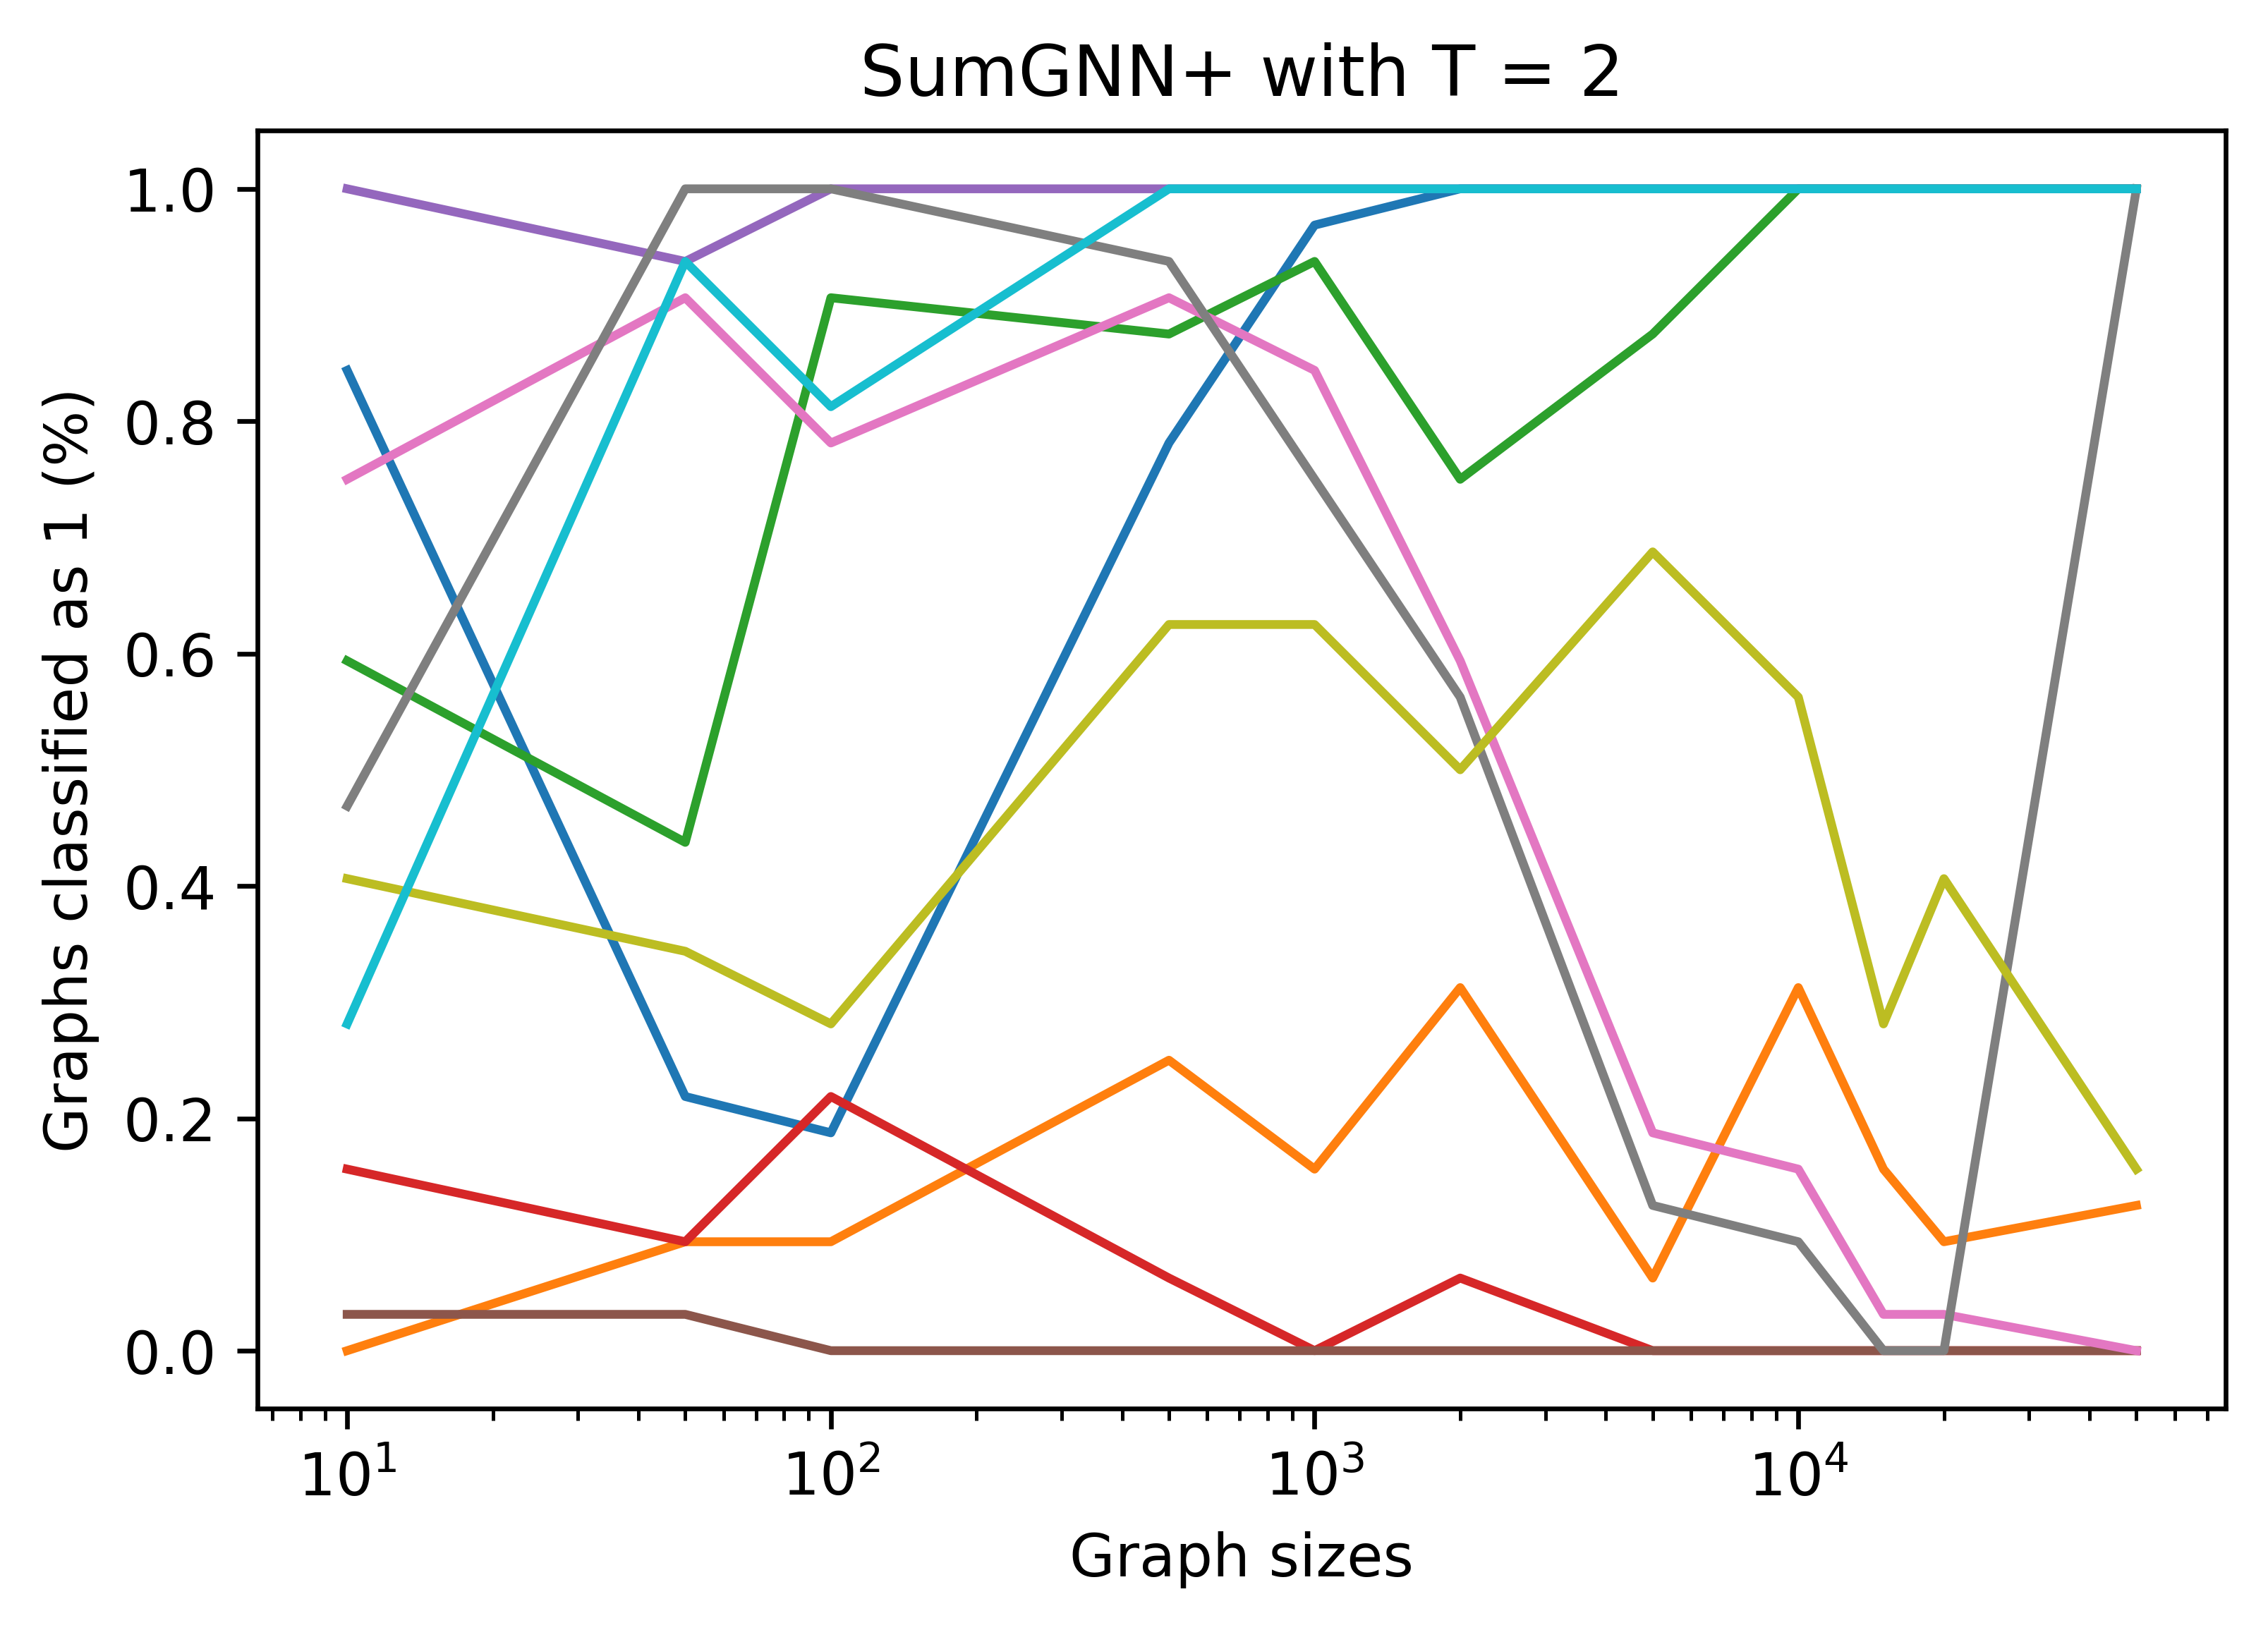

In [ ]:
for idx,y in enumerate(csv_numLayer_2):
  y = [item/32 for item in y] + [ext_csv_numLayer_2[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'SumGNN+ with T = 2')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/Added_SumGNN+ with T = 2')
plt.show()

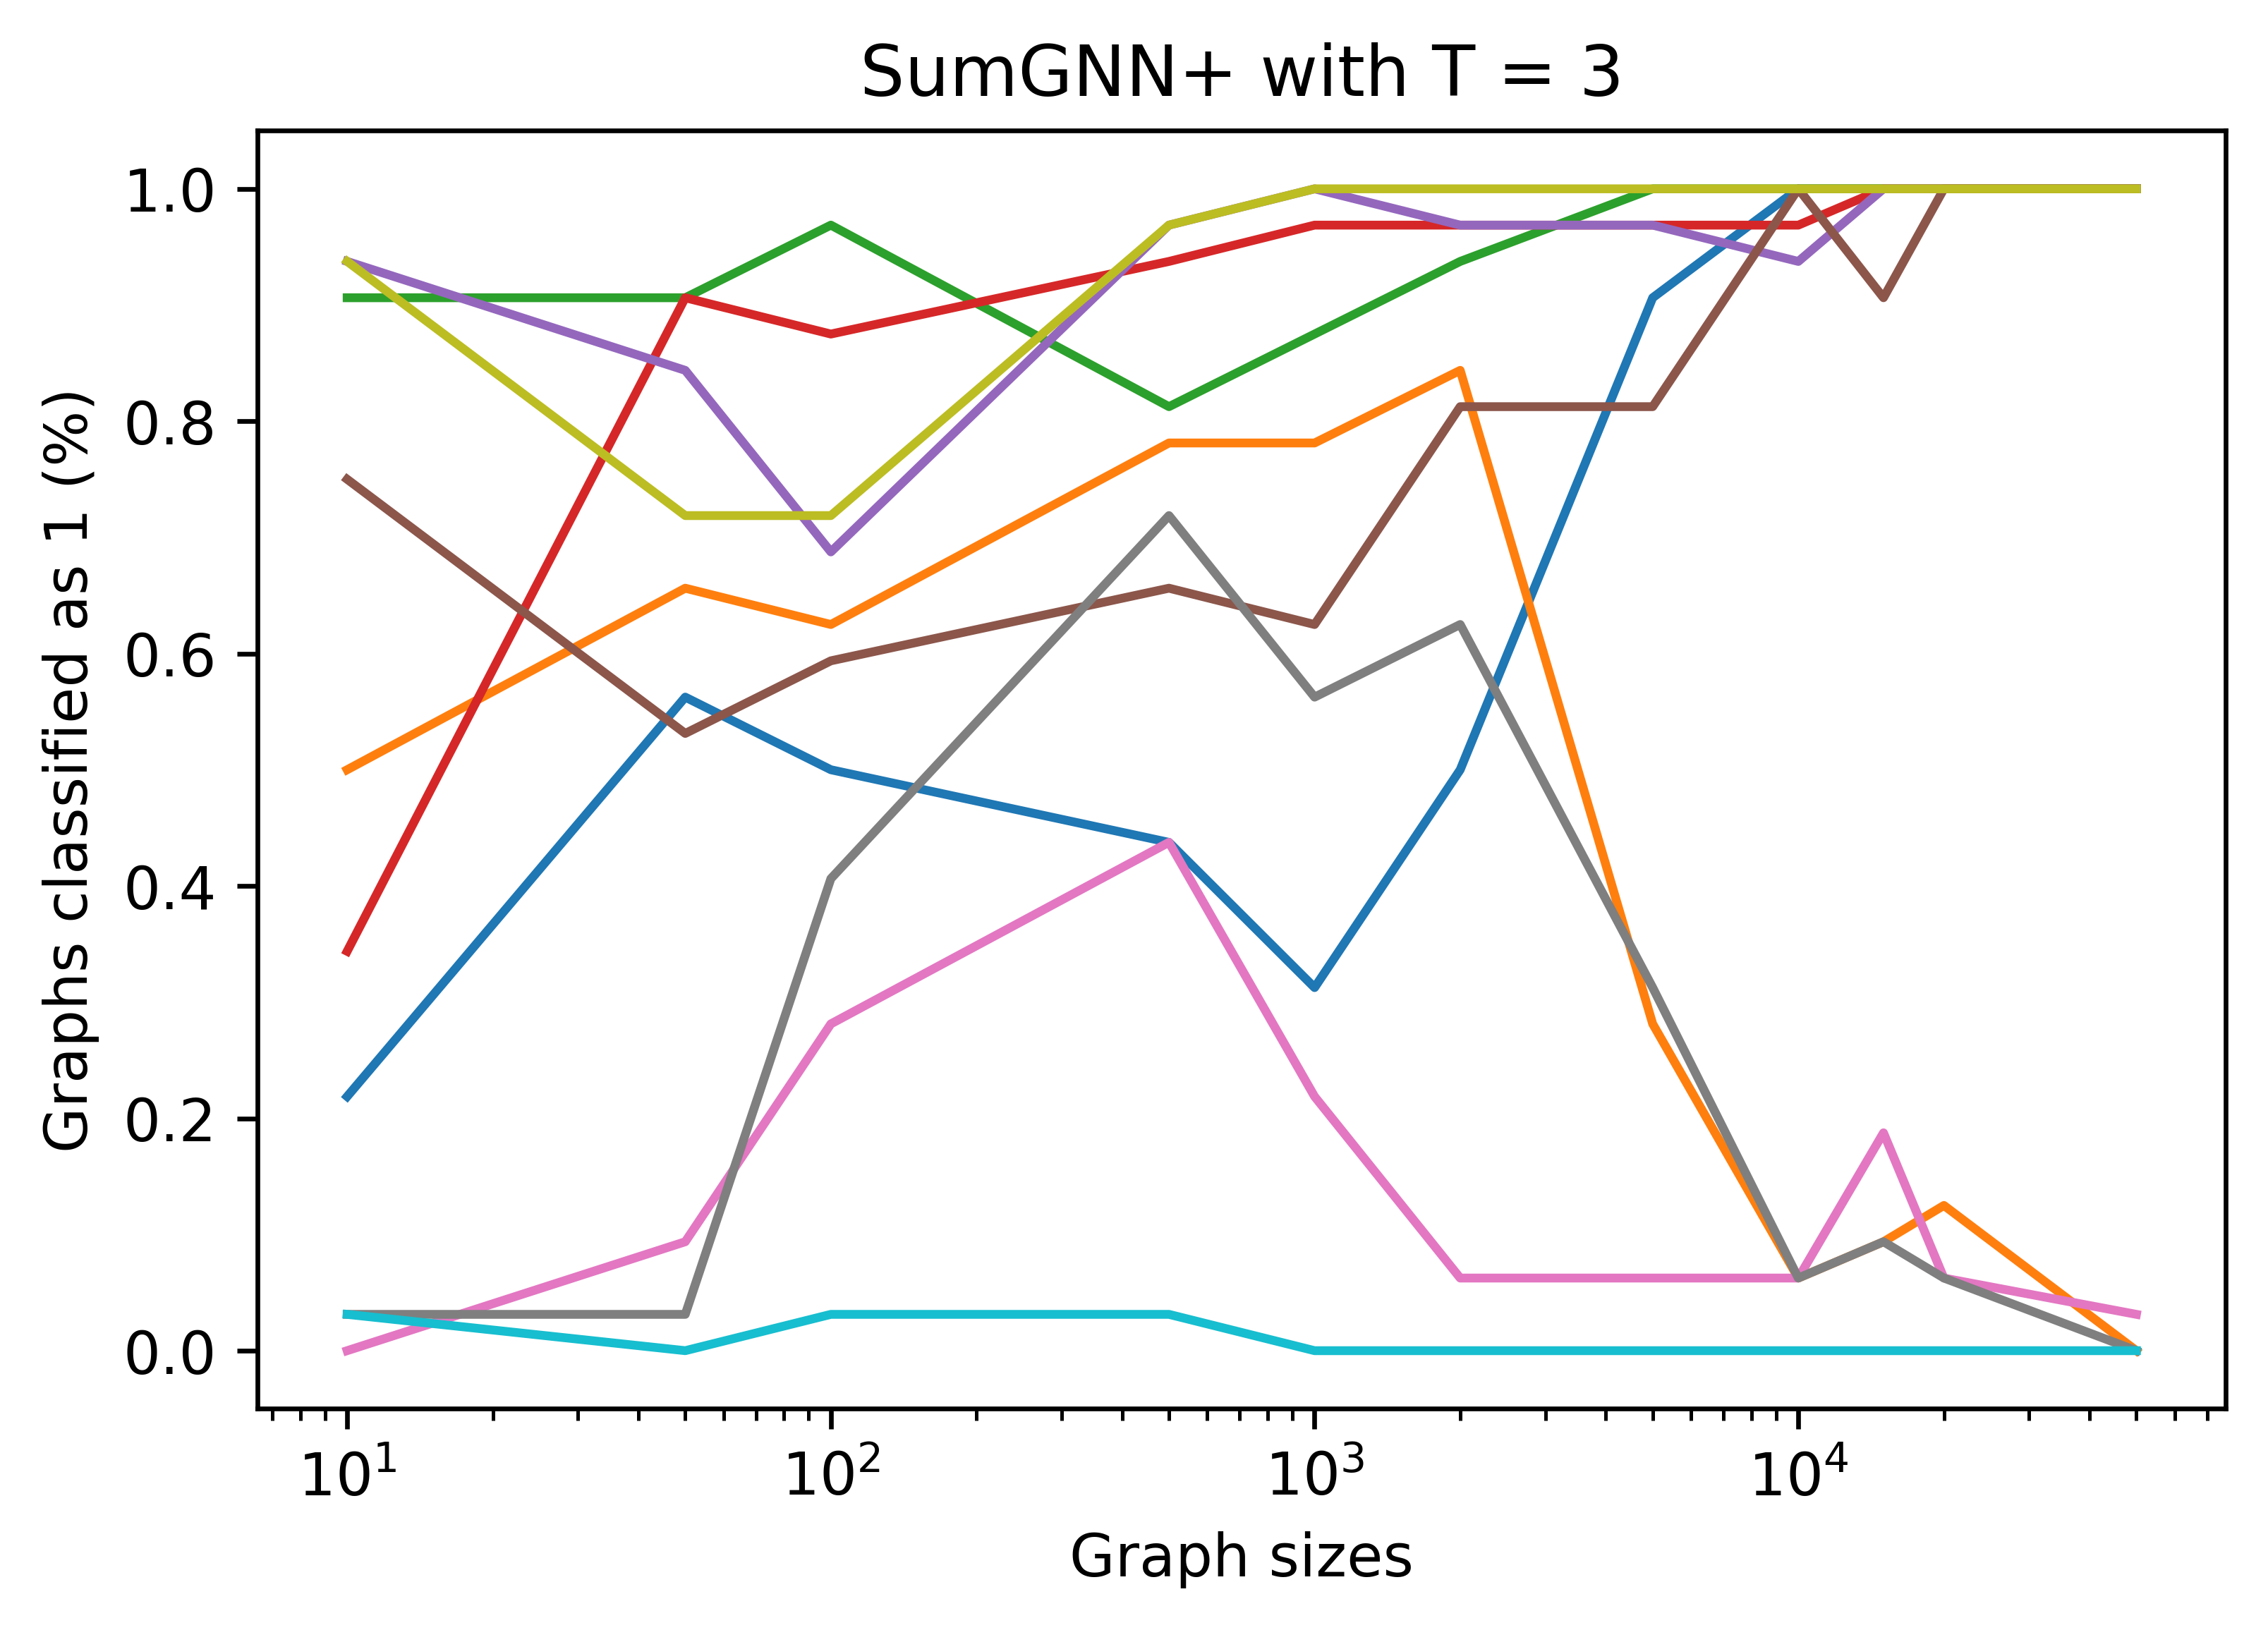

In [ ]:
for idx,y in enumerate(csv_numLayer_3):
  y = [item/32 for item in y] + [ext_csv_numLayer_3[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'SumGNN+ with T = 3')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/Added_SumGNN+ with T = 3')
plt.show()

In [ ]:
import time
time.sleep(1000000)